# Analysis of Argo and Seal data South of 60S

### Temperature and Salinity

##### by Nick Young and Fabio Machado 

In [1]:
from netCDF4 import Dataset, num2date
from datetime import datetime
import glob
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import calendar
import csv
from scipy.stats import describe
from scipy import interpolate
from tqdm import tqdm_notebook as tqdm
import oceansdb
#import seawater as sw
#from seawater.library import T90conv

In [2]:
def load_netcdf(path = "Argo_South_60"):
    # load_netcdf function input: path - default is "Argo_South_60"
    files = glob.glob("data/" + path + "/**/*.nc", recursive=True)
    # glob.glob - returns a list of all the files in a given folder with the extension 'nc'
    # recursive=true - keeps on looking for all the files till the end, or the last file that exist
    
    # creating lists working on objects
    data = {
        "lat": [],
        "lon": [],
        "datetime": [],
        "pressure": [],
        "temperature": [],
        "salinity": []
    }
    
    for f in tqdm(files):
        # tqdm - make your loops show a progress meter
        d = Dataset(f)
        ####filename = "{}".format(f)
        
        # DATASET - Creating/Opening/Closing a netCDF file. 
        #This is the method used to open an existing netCDF file.
        lat = d.variables["LATITUDE"][:]
        mask = lat < -60
        lon = d.variables["LONGITUDE"][:]
        data["lat"].extend(lat[mask])
        data["lon"].extend(lon[mask])
        #1 The extend () method adds the specified list elements to the end of the current list.
        #2 This method does not return any value but add the content to existing list.
        juld = d.variables["JULD"][:]
        units = d.variables["JULD"].getncattr('units')
        #1 getncattr - reads the attributes of given variable i.e units
        dates = num2date(juld, units, "standard")
        #1 num2date - converts the format of the loaded datetime to standard format YYYY-MM-dd
        data["datetime"].extend(dates[mask])
        data["pressure"].extend(d.variables["PRES_ADJUSTED"][:][mask])
        data["temperature"].extend(d.variables["TEMP_ADJUSTED"][:][mask])
        try:
            data["salinity"].extend(d.variables["PSAL_ADJUSTED"][:][mask])
        except:
            data["salinity"].extend(np.full(len(mask), np.nan))
    
    #1 array() - allows one to do operations on a list
    #2 NumPy was imported as np
    #3 If we want to do math on a homogeneous array of numeric data, then it is much better to use NumPy, 
    #  which can automatically vectorize operations on complex multi-dimensional arrays
    
    for k,v in data.items():
        data[k] = np.array(v)
    return data

def plot(lats, lons, z = [], title = "Argo profiles south of 60S", cbtitle = "Number of points in bin", vmax=None):
    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    fig = plt.figure(figsize=(15,15))
    m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='black',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-60, 0, 20))
    m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
    #m.drawmapboundary(fill_color='aqua')
    plt.title("{} {}".format(len(lats), title))

    x, y = m(lons, lats)
    if len(z) == 0:
        hh, locx, locy = np.histogram2d(x, y, bins=100)
        # Sort the points by density, so that the densest points are plotted last
        z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
        #print(describe(z))
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    #m.imshow(heatmap, interpolation='bicubic', cmap="jet")
    m.scatter(x, y, c=z, s=5, alpha=1, cmap="jet", vmax=vmax)
    cb = plt.colorbar()
    cb.set_label(cbtitle, rotation=270)
    plt.show()

def plot_time(dts, title, label):
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    for i, dt in enumerate(dts):
    #1 enumerate() method adds a counter to an iterable and returns it in a form of enumerate object.
    #  This enumerate object can then be used directly in for loops or be converted into a list of tuples using list() method.
        k = label[i]
        df = pd.DataFrame({k: dt})
        #1 Pandas was imported as pd
        #2 Dataframe class - class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
        #  Two-dimensional size-mutable, potentially heterogeneous tabular data structure with labeled axes (rows and columns).
        #  Arithmetic operations align on both row and column labels. 
        #  Can be thought of as a dict-like container for Series objects
        df = df.groupby(by=df[k].dt.date).count()
        #1 groupby - groups data by a certain specified variable type
        df.plot(ax=ax, style='.', markersize=3)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.set_title(title, fontsize=18)
        ax.set_xlabel("Time",fontsize=14)
        ax.set_ylabel("Number of profiles",fontsize=14)
        #ax.set_xlabel("")
        ax.legend(fontsize=14)
    plt.show()

In [3]:
argo = load_netcdf()

In [ ]:
plot(argo["lat"], argo["lon"], vmax=100)
sst = [x[0] for x in argo["temperature"]]
plot(argo["lat"], argo["lon"], sst, title = "Argo SST", cbtitle = "Temperature °C")
max_depth = [np.nanmax(x) for x in argo["pressure"]]
plot(argo["lat"], argo["lon"], max_depth, title = "Argo Max Depth", cbtitle = "Depth (decibar pressure)")

In [ ]:
print(min(argo["datetime"]), max(argo["datetime"]))
plot_time([argo["datetime"]], "Argo float dailystamps", ["Argo"])

In [4]:
seal = load_netcdf("seal")

In [ ]:
plot(seal["lat"], seal["lon"], title = "Seal data south of 60S", vmax=100)
sst = [x[0] for x in seal["temperature"]]
plot(seal["lat"], seal["lon"], sst, title = "Seal SST", cbtitle = "Temperature °C")
max_depth = [np.nanmax(x) for x in seal["pressure"]]
plot(seal["lat"], seal["lon"], max_depth, title = "Seal Max Depth", cbtitle = "Depth (decibar pressure)")

In [ ]:
print(min(seal["datetime"]), max(seal["datetime"]))
plot_time([seal["datetime"]], "Seal data dailystamps", ["Elephant seal"])

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:60: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


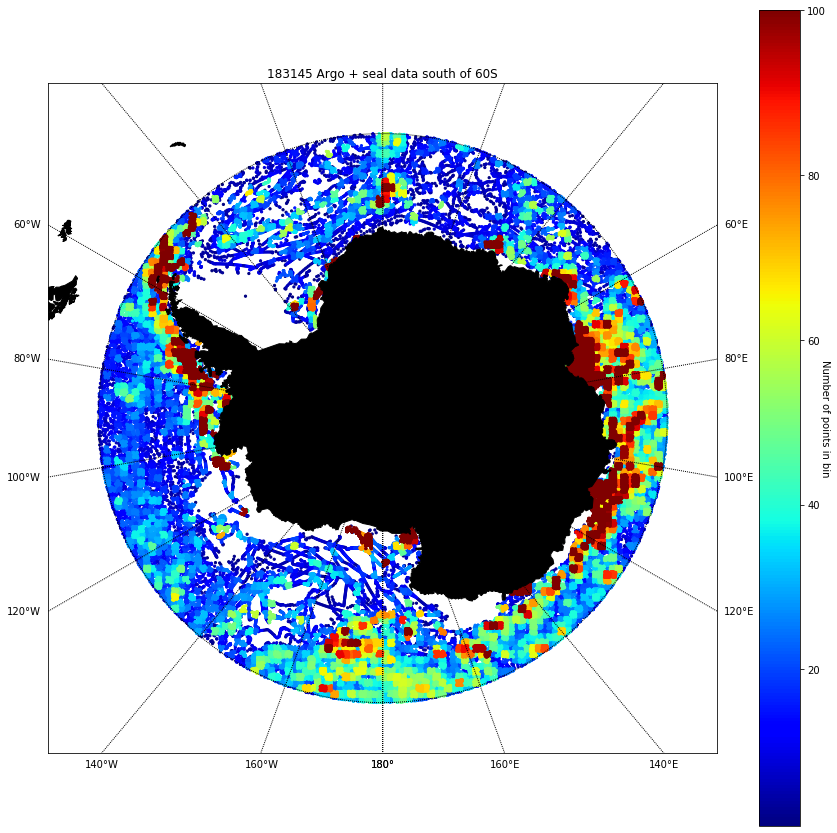

In [5]:
all_lats = np.concatenate((seal["lat"], argo["lat"]))
all_lons = np.concatenate((seal["lon"], argo["lon"]))
plot(all_lats, all_lons, title="Argo + seal data south of 60S", vmax=100)

In [ ]:
plot_time([seal["datetime"], argo["datetime"]], "Argo + seal data dailystamps", ["Seal", "Argo"])

In [ ]:
a3_sum = sum(argo["lat"]> -89.)
mask_out = argo["lat"] < -75
mask_in = (argo["lat"] < -60) & (argo["lat"] > -75)
a1_sum = sum(mask_out)
a2_sum = sum(mask_in)
print("Argo","\nA) Number of profiles to the south of 75S =",a1_sum,
      "\nB) Number of profiles between 60 and 75S =", a2_sum, 
      "\nC) A+B =", (a2_sum+a1_sum),
      "\nD) Total number of profiles to the south of 60S =", a3_sum)

s1_sum = sum(seal["lat"]> -89.)
mask_half_out = (seal["lat"] < -60) & (seal["lat"] > -89)
s2_sum = sum(mask_half_out)
mask_out = seal["lat"] < -75
mask_in = (seal["lat"] < -60) & (seal["lat"] > -75)
s3_sum = sum(mask_out)
s4_sum = sum(mask_in)
print("Seal","\nE) Number of profiles to the south of 75S =",s3_sum, 
      "\nF) Number of profiles between 60 and 75S =", s4_sum, 
      "\nG) E+F =", (s4_sum+s3_sum), 
      "\nH) Total number of profiles to the south of 60S =", s1_sum, 
      "\nI) Total number of profiles to the south of 60S =",s2_sum)

In [6]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(-1.5, 1950, "4.%d" % (i+1), va="center", ha="center", fontsize=12, color='black')
        ax1.text(-1., 1950, "Total of Seal Profiles = {}".format(n_seal_profiles), 
                 va="center", ha="left", fontsize=12, color='black')
        ax3.text(-1., 1950, "Total of Argo Profiles = {}".format(n_argo_profiles), 
                 va="center", ha="left", fontsize=12, color='black')
        #ax1.text(2., 1750, 'Boundaries:\nLat (-{})-(-{})\nLon ({})-({})'.format(lat_i,lat_f,lon_i,lon_f), 
        #        va="center", ha="center", fontsize=12, color='black')
        ax.set_ylim(p_max, p_min); 
        ax.set_xlim(t_min, t_max)
        ax.tick_params(axis="both", direction='inout', which='major', labelsize=16)
        ax1.tick_params(labelbottom=False, labelleft=True)
        ax2.tick_params(labelbottom=False, labelleft=False)
        ax3.tick_params(labelbottom=True, labelleft=True)
        ax4.tick_params(labelbottom=True, labelleft=False)

seal 16
[23479 60686 60695 60830 60831 60832 62393 62857 64169 67048 67063 67064
 68062 68426 96272 96273]


c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


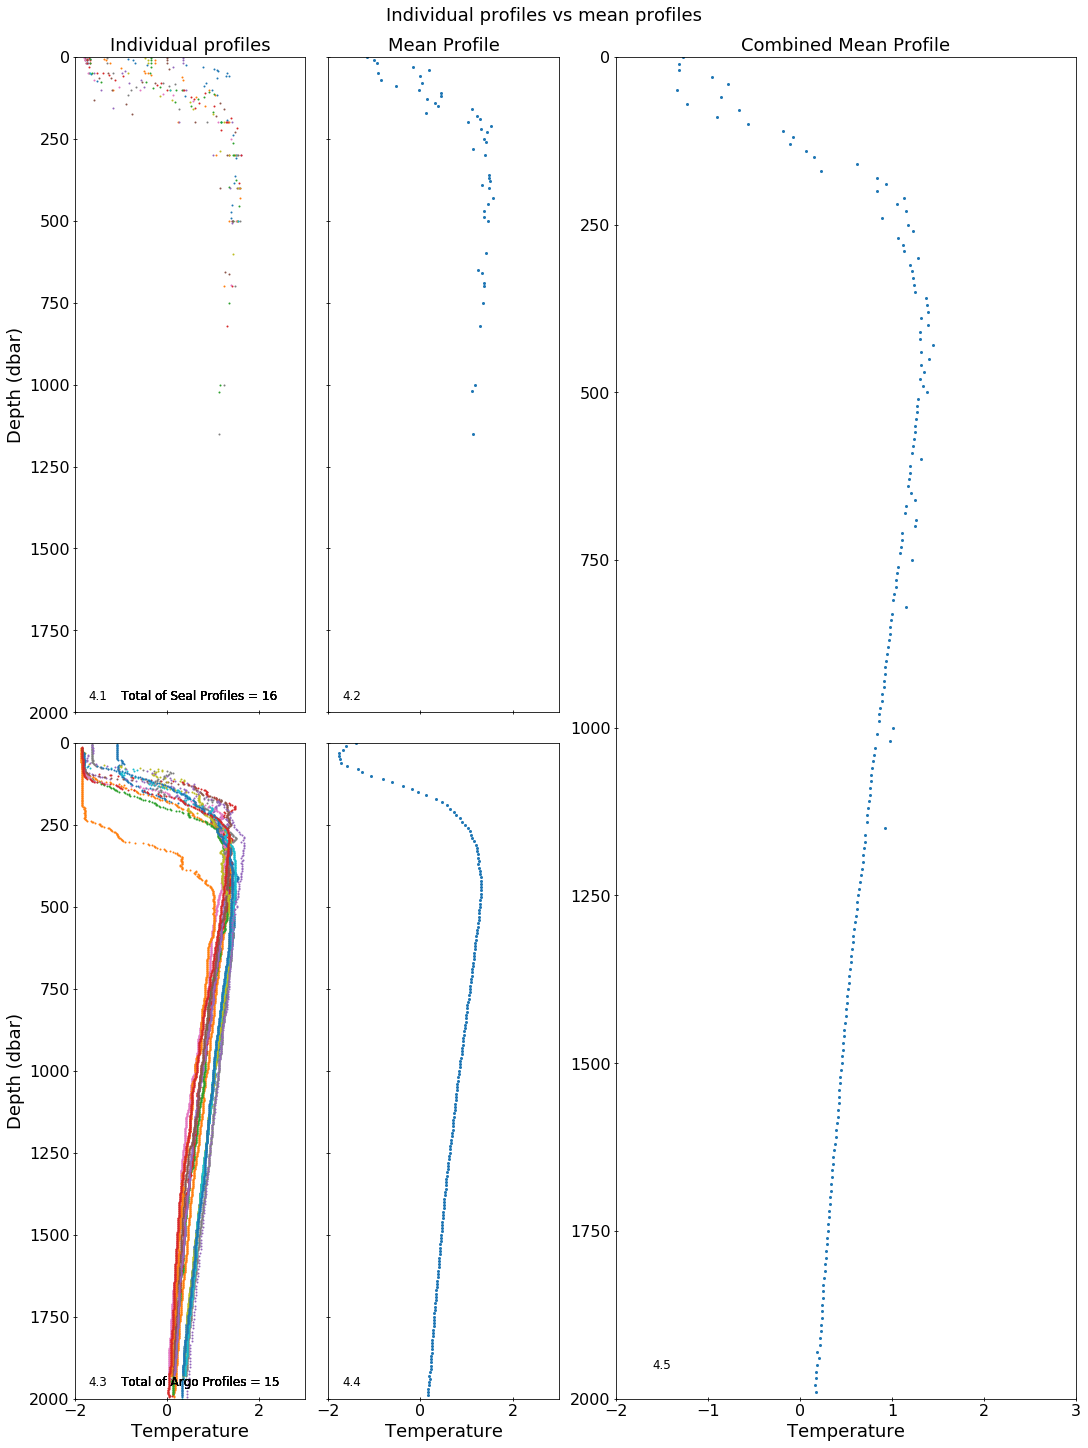

In [9]:
# This subroutine plot Seal Vertical Profiles and the Mean Profile from the Grid System
# It is necessary to run the subroutine ...
#   where "argo_temp_grid_withdepth" or "argo_sal_grid_withdepth" is calculated
        
fig = plt.figure(constrained_layout=True, figsize=(15,20))

gs = GridSpec(3, 4, figure=fig)

# Defining Geographycal Boundaries
lat_i = 63.25 ; lat_f = 63.75 ; 
# i = northermost # f = southermost 
lon_i = 105.25 ; lon_f = 105.75; 
# i = westermost # f = eastermost 

# Grid system cell related to the geographycal boundaries
lat_grid = 7; lon_grid = 571;

# Maximum and minimum Temperature in the plot
t_max = 3; t_min = -2;
# Maximum and minimum Salinity in the plot
s_max = 36.; s_min = 33.;
# Maximum and minimum Temperature in the plot
p_max = 2000; p_min = 0;

mask_seal = ((seal["lat"] < -lat_i) & (seal["lat"] > -lat_f) & (seal["lon"] > lon_i) & (seal["lon"] < lon_f))  
mask_argo = ((argo["lat"] < -lat_i) & (argo["lat"] > -lat_f) & (argo["lon"] > lon_i) & (argo["lon"] < lon_f)) 

n_seal_profiles = len(np.flatnonzero(mask_seal))
n_indivivual_profiles = len(np.flatnonzero(mask_seal))
n_argo_profiles = len(np.flatnonzero(mask_argo))
print("seal", len(np.flatnonzero(mask_seal)))
print(np.flatnonzero(mask_seal))

depth = np.arange(p_min, p_max, 10)
xaxis = np.arange(t_min, t_max, 1)

for i in np.flatnonzero(mask_seal):
    temp_seal = seal["temperature"][i]
    pressure_seal = seal["pressure"][i]
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(temp_seal, pressure_seal,'.', markersize=2)
ax1.set_ylabel("Depth (dbar)", fontsize="18")
ax1.set_title("Individual profiles".format(n_seal_profiles), fontsize="18")


ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(seal_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
ax2.set_title("Mean Profile", fontsize="18")

for i in np.flatnonzero(mask_argo):
    temp_argo = argo["temperature"][i]
    pressure_argo = argo["pressure"][i]
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(temp_argo, pressure_argo,'.', markersize=2)
ax3.set_xlabel("Temperature", fontsize="18"); 
ax3.set_ylabel("Depth (dbar)", fontsize="18")

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(argo_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
ax4.set_xlabel("Temperature", fontsize="18")

ax5 = fig.add_subplot(gs[:, 2:])
ax5.plot(combined_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
ax5.set_xlabel("Temperature", fontsize="18")
#ax5.tick_params(axis="y", direction='inout', labelsize=16)
#ax5.tick_params(axis="x", direction='inout', labelsize=16)
#ax5.set_ylim(2000, 0); 
#ax5.set_xlim(t_min, t_max)
ax5.set_title("Combined Mean Profile", fontsize="18")

#fig.suptitle('Boundaries: Lat (-{})-(-{}) - Lon ({})-({})\nCel grid: Lat (-{}) - Lon ({})'.format(lat_i,lat_f,lon_i,lon_f,lat_grid, lon_grid), fontsize="18")
fig.suptitle("Individual profiles vs mean profiles", fontsize="18")
format_axes(fig)

plt.show()

In [10]:
import pylab as plot
params = {'legend.fontsize': 14,
          'legend.handlelength': 1,
          'legend.labelspacing': 0.25,
          'legend.handletextpad': 0.2,
          'legend.frameon': False,
          'legend.markerscale': 2.0}
plot.rcParams.update(params)

def format_axes_a(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(-1.5, 1950, "4.%d" % (i+1), va="center", ha="center", fontsize=14, color='black')
        ax.tick_params(axis="both", direction='inout', which='major', labelsize=16, labelbottom=True, labelleft=True)
        ax.set_ylim(p_max, p_min); 
        ax.set_xlim(t_min, t_max)
        ax1.set_ylabel("Depth (dbar)", fontsize="18")
        ax2.set_ylabel("Depth (dbar)", fontsize="18")
        ax2.set_xlabel("Temperature", fontsize="18")
        ax4.set_xlabel("Temperature", fontsize="18")
        ax6.set_xlabel("Temperature", fontsize="18")
        ax1.tick_params(labelbottom=False)
        ax3.tick_params(labelbottom=False, labelleft=False)
        ax4.tick_params(labelleft=False)
        ax5.tick_params(labelbottom=False)

seal 16
[23479 60686 60695 60830 60831 60832 62393 62857 64169 67048 67063 67064
 68062 68426 96272 96273]


c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
No handles with labels found to put in legen

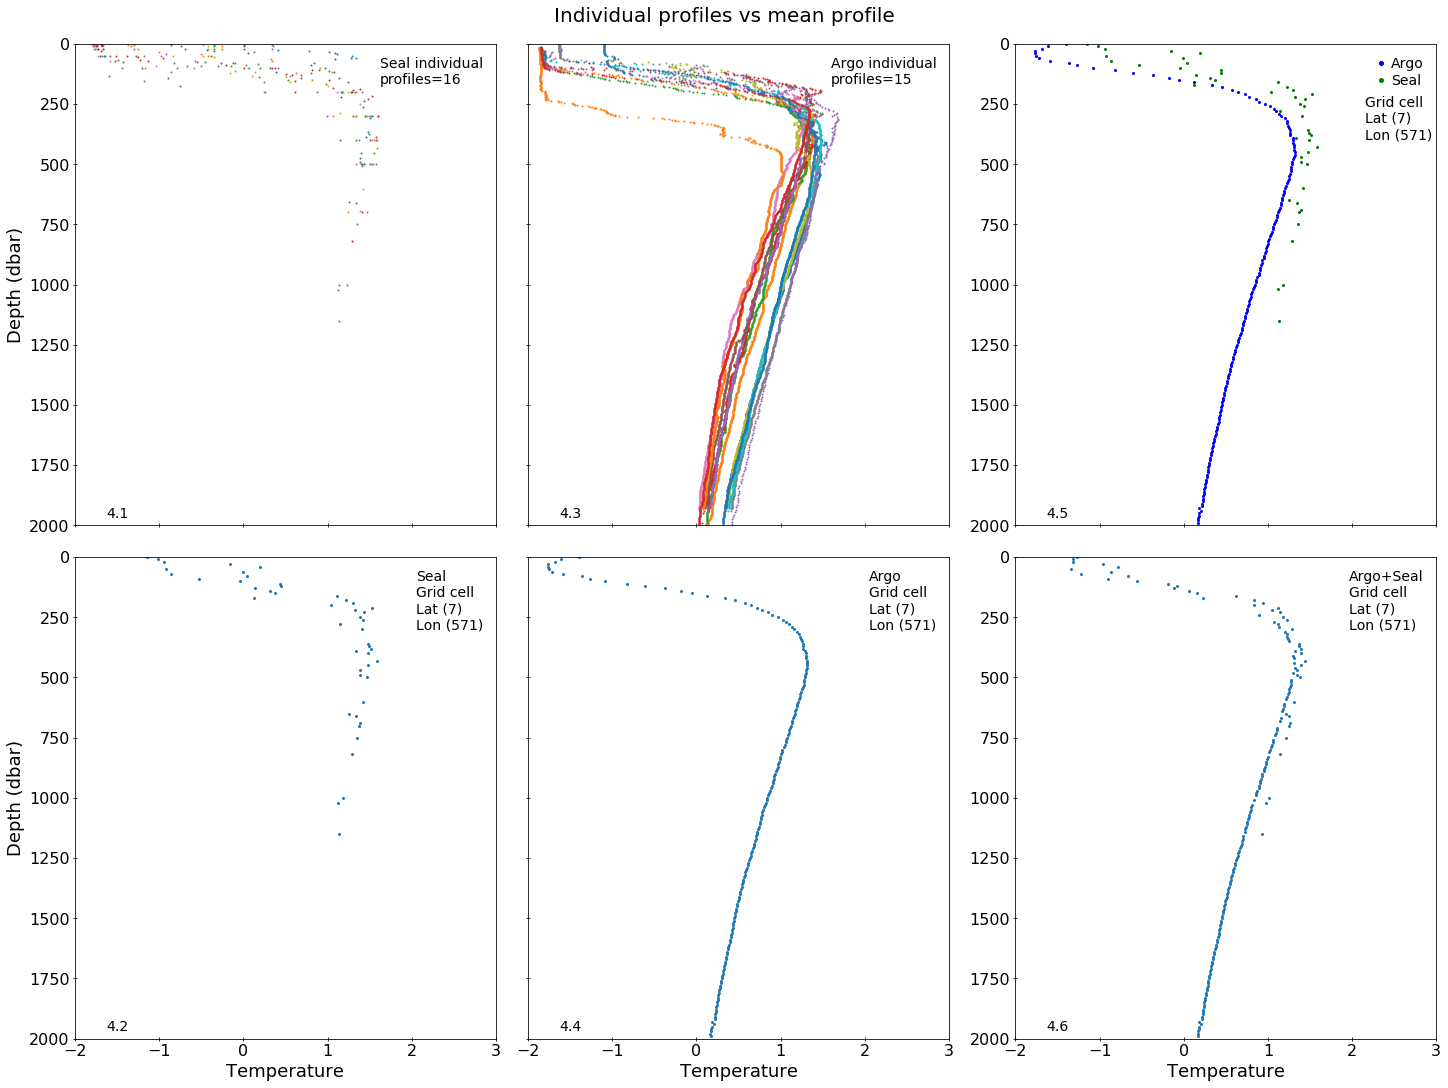

In [11]:
# This subroutine plot Seal Vertical Profiles and the Mean Profile from the Grid System
# It is necessary to run the subroutine ...
#   where "argo_temp_grid_withdepth" or "argo_sal_grid_withdepth" is calculated
        
fig = plt.figure(constrained_layout=True, figsize=(20,15))

gs = GridSpec(2, 3, figure=fig)

# Defining Geographycal Boundaries
lat_i = 63.25 ; lat_f = 63.75 ; 
# i = northermost # f = southermost 
lon_i = 105.25 ; lon_f = 105.75; 
# i = westermost # f = eastermost 

# Grid system cell related to the geographycal boundaries
lat_grid = 7; lon_grid = 571;

# Maximum and minimum Temperature in the plot
t_max = 3; t_min = -2;
# Maximum and minimum Salinity in the plot
s_max = 36.; s_min = 33.;
# Maximum and minimum Temperature in the plot
p_max = 2000; p_min = 0;

fontsize = 14

# defining the "area of interest"
mask_seal = ((seal["lat"] < -lat_i) & (seal["lat"] > -lat_f) & (seal["lon"] > lon_i) & (seal["lon"] < lon_f))  
mask_argo = ((argo["lat"] < -lat_i) & (argo["lat"] > -lat_f) & (argo["lon"] > lon_i) & (argo["lon"] < lon_f)) 

# calculate the number of Argo and Seal profiles within the "area of interest" defined above
n_seal_profiles = len(np.flatnonzero(mask_seal))
n_indivivual_profiles = len(np.flatnonzero(mask_seal))
n_argo_profiles = len(np.flatnonzero(mask_argo))
print("seal", len(np.flatnonzero(mask_seal)))
print(np.flatnonzero(mask_seal))

depth = np.arange(p_min, p_max, 10)
xaxis = np.arange(t_min, t_max, 1)

for i in np.flatnonzero(mask_seal):
    temp_seal = seal["temperature"][i]
    #sal_seal = seal["salinity"][i]
    pressure_seal = seal["pressure"][i]
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(temp_seal, pressure_seal,'.', markersize=2)
#ax1.set_title("Seal profiles".format(n_seal_profiles), fontsize="18")
plt.legend(title='Seal individual\nprofiles={}'.format(n_seal_profiles), loc='upper right', title_fontsize=fontsize)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(seal_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
plt.legend(title='Seal\nGrid cell\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), loc='upper right', title_fontsize=fontsize)

for i in np.flatnonzero(mask_argo):
    temp_argo = argo["temperature"][i]
    pressure_argo = argo["pressure"][i]
    ax3 = fig.add_subplot(gs[0, 1])
    ax3.plot(temp_argo, pressure_argo,'.', markersize=2)
#ax3.set_title("Argo profiles".format(n_seal_profiles), fontsize="18") 
plt.legend(title='Argo individual\nprofiles={}'.format(n_argo_profiles), loc='upper right', title_fontsize=fontsize)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(argo_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
plt.legend(title='Argo\nGrid cell\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), loc='upper right', title_fontsize=fontsize)

ax5 = fig.add_subplot(gs[0, 2])
ax5.plot(argo_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.b', markersize=4, label='Argo')
ax5.plot(seal_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.g', markersize=4, label='Seal')
plt.legend(loc='upper right', title_fontsize=fontsize)
ax5.text(2.15, 310, "Grid cell\nLat ({})\nLon ({})".format(lat_grid,lon_grid), 
                 va="center", ha="left", fontsize=fontsize, color='black')

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(combined_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
plt.legend(title='Argo+Seal\nGrid cell\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), 
           loc='upper right', title_fontsize=fontsize)
#ax5.tick_params(axis="y", direction='inout', labelsize=16)
#ax5.tick_params(axis="x", direction='inout', labelsize=16)
#ax5.set_ylim(2000, 0); 
#ax5.set_xlim(t_min, t_max)
#ax6.set_title("Combined Mean Profile", fontsize="18")



#fig.suptitle('Boundaries: Lat (-{})-(-{}) - Lon ({})-({})\nCel grid: Lat (-{}) - Lon ({})'.format(lat_i,lat_f,lon_i,lon_f,lat_grid, lon_grid), fontsize="18")
fig.suptitle("Individual profiles vs mean profile", fontsize="20")

format_axes_a(fig)

plt.show()

In [23]:
def load_netcdf_grid(path = "Argo_South_60", resolution = 1, target_var = "temp", 
                     with_depth = False, filter_month = None, filter_season = None, 
                     filter_start = datetime(2000,1,1), filter_end = datetime(2021,1,1)):
    if with_depth:
        grid = np.full(shape=[15 * resolution, 360 * resolution, 200], fill_value=np.nan)
        gridcounts = np.zeros(shape=[15 * resolution, 360 * resolution, 200])
    else:
        grid = np.full(shape=[15 * resolution, 360 * resolution], fill_value=np.nan)
    files = glob.glob("data/{}/**/*.nc".format(path), recursive=True)
    #1 glob.glob - returns a list of all the files in a given folder with the extension 'nc'
    #2 recursive=true - keeps on looking for all the files till the end, or the last file that exist
    
    
    # creating lists
    filename2 = []
    nbprof2 = [] 
    filename2_maskout = []
    ## End of "creating lists"
    
    for f in tqdm(files[:]):
    # tqdm - make your loops show a progress meter
        d = Dataset(f)
        #1 DATASET - Creating/Opening/Closing a netCDF file. 
        # This is the method used to open an existing netCDF file.
        lat = d.variables["LATITUDE"][:]
        mask = (lat < -60) & (lat > -74.5)
        
        # Counting number of profiles per NetCDF files
        nbprof = [len(lat)] # number of profiles per file
        nbprof2.extend(nbprof)
        # filename = filename
        filename = ["Filename {}".format(f)]
        filename2.extend(filename)
        #Create a DataFrame: filename + number of profiles per file    
        profiles_per_files = {'Filename': filename2, 'Number of profiles per file': nbprof2}
        new_df = pd.DataFrame(data=profiles_per_files)
        #Save "new_df" as csv file:  
        new_df.to_csv('filename_nbprof.csv', index=False)
        ## End of "Counting number of profiles per NetCDF files"
        
        juld = d.variables["JULD"][:]
        units = d.variables["JULD"].getncattr('units')
        dates = num2date(juld, units, "standard")
        datemask = (dates > filter_start) & (dates < filter_end)
        mask &= datemask
        if filter_month:
            datemask = np.array([d.month == filter_month for d in dates])
            mask &= datemask
        if filter_season:
            if filter_season == "Summer":
                datemask = np.array([d.month >= 10 or d.month <= 3 for d in dates])
            elif filter_season == "Winter":
                datemask = np.array([d.month > 3 and d.month < 10 for d in dates])
            mask &= datemask
        if any(mask):
            lat = np.round((np.abs(lat[mask]) - 60) * resolution).astype(int)
            lon = d.variables["LONGITUDE"][mask]
            lon = np.round((lon + 180) * resolution).astype(int)
            lon[lon == 360 * resolution] = 0
            if with_depth:
                #pres = np.round(d.variables["PRES_ADJUSTED"][mask] / 10).astype(int)
                pres = np.floor(d.variables["PRES_ADJUSTED"][mask] / 10).astype(int)
                temp = d.variables["TEMP_ADJUSTED"][mask]
                if target_var == "sal":
                    try:
                        sal = d.variables["PSAL_ADJUSTED"][mask]
                    except:
                        print("No salinity for {}".format(f))
                        continue
            else:
                pres = d.variables["PRES_ADJUSTED"][mask]
                temp = d.variables["TEMP_ADJUSTED"][mask, 0]
            for x in np.unique(lon):
                for y in np.unique(lat):
                    if with_depth:
                        ptmask = (lon == x) & (lat == y)
                        for z in np.unique(pres[ptmask]):
                            if z>= 200 or np.ma.is_masked(z):
                                continue
                            depthmask = pres[ptmask] == z
                            if target_var == "temp":
                                values_at_pt = temp[ptmask][depthmask].compressed()
                            elif target_var == "sal":
                                values_at_pt = sal[ptmask][depthmask].compressed()
                            grid[y, x, z] = np.nansum((grid[y,x,z], np.nansum(values_at_pt)))
                            gridcounts[y, x, z] += len(values_at_pt)
                    else:
                        ptmask = (lon == x) & (lat == y)
                        if target_var == "n_point":
                            v = np.sum(ptmask)
                            if not np.ma.is_masked(v):
                                if v != 0:                                   
                                #1 added a if statement checking if number of points is greater than 0
                                    grid[y, x] = np.nansum((grid[y, x], v))
                        elif target_var == "temp":
                            temps_at_pt = temp[ptmask]
                            v = np.ma.mean(temps_at_pt)
                            # numpy.std -->> Standard deviation
                            sd = np.ma.std(temps_at_pt)
                            if not np.ma.is_masked(v):
                                grid[y, x] = np.nanmean((grid[y, x], v))
                        elif target_var == "depth":
                            pres_at_pt = pres[ptmask]
                            if len(pres_at_pt):
                                v = np.ma.max(pres[ptmask])
                                if not np.ma.is_masked(v):
                                    grid[y, x] = np.nanmax((grid[y, x], v))
    if with_depth:
        grid /= gridcounts
        print(np.nanmin(grid), np.nanmean(grid), np.nanmax(grid))
    return grid

# This version seems a lot more inefficient for some reason
def load_netcdf_grid_new(platform = "argo", resolution = 1, target_var = "temp", filter_month = None, filter_season = None, filter_start = datetime(2000,1,1), filter_end = datetime(2020,1,1)):
    grid = np.full(shape=[15 * resolution, 360 * resolution, 200], fill_value=np.nan)
             
    if platform == "argo":
        data = argo
    else:
        data = seal
    mask = (data["lat"] < -60) & (data["lat"] > -74.5)
    datemask = (data["datetime"] > filter_start) & (data["datetime"] < filter_end)
    mask &= datemask
    if filter_month:
        datemask = np.array([d.month == filter_month for d in data["datetime"]])
        mask &= datemask
    if filter_season:
        if filter_season == "Summer":
            datemask = np.array([d.month >= 10 or d.month <= 3 for d in data["datetime"]])
        elif filter_season == "Winter":
            datemask = np.array([d.month > 3 and d.month < 10 for d in data["datetime"]])
        mask &= datemask
    if any(mask):
        lat = np.round((np.abs(data["lat"][mask]) - 60) * resolution).astype(int)
        lon = data["lon"][mask]
        lon = np.round((lon + 180) * resolution).astype(int)
        lon[lon == 360 * resolution] = 0
        for y in tqdm(np.unique(lat)):
            for x in tqdm(np.unique(lon)):
                ptmask = (lon == x) & (lat == y)
                depths = set()
                for pres in data["pressure"][mask][ptmask]:
                    print(np.floor(pres / 10).compressed().astype(int))
                    depths.update(np.floor(pres / 10).compressed().astype(int))
                print(len(depths))
                for z in tqdm(depths):
                    depthmask = [np.floor(pres / 10) == z for pres in data["pressure"][mask][ptmask]]
                    values = []
                    for i in range(len(depthmask)):
                        values.extend(data["temperature"][mask][ptmask][i][depthmask[i]])
                    #print(values)
                    grid[y, x, z] = np.ma.mean(values)
    return grid

def plot_grid(grid, resolution = 1, title="Argo data\n0-10 decibars mean temperature", cbtitle="Temperature °C", vmin=None, vmax=None):
    fig = plt.figure(figsize=(15,15))
    m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='black',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-60, -80, -5))
    m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
    #m.drawmapboundary(fill_color='aqua')
    #plt.title("{}".format(title, 1/resolution),fontsize = 16)
    plt.title("\n{} at {}° resolution".format(title, 1/resolution),fontsize = 16)

    x = np.arange(-180, 180.1, 1/resolution)
    y = np.arange(-60, -75.1, 1/-resolution)
    x, y = np.meshgrid(x, y)
    x, y = m(x, y)

    m.pcolormesh(x, y, grid, cmap="jet", vmin=vmin, vmax=vmax)
    cb = plt.colorbar()
    cb.set_label(cbtitle, labelpad= 15, rotation=270, fontsize = 12)
    plt.show()
    
def interp_nans(grid, method='linear'):
    x = np.arange(0, grid.shape[1])
    y = np.arange(0, grid.shape[0])
    mask = np.isnan(grid)
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~mask]
    y1 = yy[~mask]
    newarr = grid[~mask]
    interp = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method=method)
    if method == "linear":
        interp = interp_nans(interp, "nearest")
    return interp

In [7]:
# Titles and labels for figures
a_title = "Argo Data"
s_title = "Seal Data"
comb_title = "Argo+Seal Data"
interp_title = "Interpolated Argo+Seal Data"
msf = "Salinity mean field "
mtf = "Temperature mean field "
msd = "Density mean field "
T_title = "Temperature"
S_title = "Salinity"
D_title = "Density"

# Maximum and Minimum - temperature and Salinity
smax = 34.8
smin = 32.5
tmax = 6
tmin = -2.5
rhomin = 1028
rhomax = 1026.5
# Grid Resolution
resolution = 2

In [ ]:
argo_pt_grid = load_netcdf_grid(target_var="n_point", with_depth = False, resolution = resolution)
seal_pt_grid = load_netcdf_grid(path="seal", target_var="n_point", with_depth = False, resolution = resolution)

In [ ]:
combined_pt_grid = np.nansum((argo_pt_grid, seal_pt_grid), axis=0)
combined_pt_grid[np.isnan(argo_pt_grid) & np.isnan(seal_pt_grid)] = np.nan
print(argo_pt_grid.shape,seal_pt_grid.shape,combined_pt_grid.shape)

In [ ]:
plot_grid(argo_pt_grid, title=a_title + "\nNumber of vertical profiles", cbtitle="Number of profiles", vmin=1,vmax=25, resolution = resolution)
plot_grid(seal_pt_grid, title=s_title + "\nNumber of vertical profiles", cbtitle="Number of profiles", vmin=1,vmax=25, resolution = resolution)
plot_grid(combined_pt_grid, title=comb_title + "\nNumber of vertical profiles", cbtitle="Number of profiles", vmin=1,vmax=25, resolution = resolution)

In [8]:
argo_temp_grid = load_netcdf_grid(resolution = resolution)
seal_temp_grid = load_netcdf_grid("seal", resolution = resolution)
print(argo_temp_grid.shape,seal_temp_grid.shape)

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\numpy\ma\core.py:5159: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\numpy\ma\core.py:5237: RuntimeWarning: Degrees of freedom <= 0 for slice
  ddof=ddof, **kwargs)[()]
c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(30, 720) (30, 720)


In [9]:
combined_temp_grid = np.nanmean((argo_temp_grid, seal_temp_grid), axis=0)
print(combined_temp_grid.shape)

c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(30, 720)


In [ ]:
#title = "Seal data gridded at {}\n0-10 decibar mean temperature\nMean across all points = {}".format(1/resolution,sealmean)
title = a_title + "\n0-10 decibars" + mtf
plot_grid(argo_temp_grid, title=title, resolution = resolution)
title = s_title + "\n0-10 decibar" + mtf
plot_grid(seal_temp_grid, title=title, resolution = resolution)
title = comb_title + "\n0-10 decibar" + mtf
plot_grid(combined_temp_grid, title=title, resolution = resolution)

In [10]:
interp = interp_nans(combined_temp_grid)

In [ ]:
#title = "Argo+Seal data gridded at {}\n0-10 decibar mean temperature\nMean across all points = {}".format(1/resolution,interpmean)
title = interp_title + "\n0-10 decibar" + mtf
plot_grid(interp, resolution = resolution, title=title)

In [ ]:
argo_max_depth = load_netcdf_grid(target_var = "depth", resolution = resolution)
seal_max_depth = load_netcdf_grid("seal", target_var = "depth", resolution = resolution)

In [ ]:
#print(argo_max_depth.shape,seal_max_depth.shape)
plot_grid(argo_max_depth, resolution = resolution, title="Argo data Max depth\n", cbtitle="Depth (dbar)")
plot_grid(seal_max_depth, resolution = resolution, title="Seal data Max depth\n", cbtitle="Depth (dbar)", vmax=2000)

In [ ]:
# Monthly temperature field
for month in range(1, 13):
    try:
        argo_temp = np.load(f"argo_temp_grid_{month}.npy")
        seal_temp = np.load(f"seal_temp_grid_{month}.npy")
        combined_temp = np.load(f"combined_temp_grid_{month}.npy")
    except:
        argo_temp = load_netcdf_grid(filter_month = month, with_depth=True)
        seal_temp = load_netcdf_grid("seal", filter_month = month, with_depth=True)
        combined_temp = np.nanmean((argo_temp, seal_temp), axis=0)
        np.save("argo_temp_grid_{}".format(month), argo_temp)
        np.save("seal_temp_grid_{}".format(month), seal_temp)
        np.save("combined_temp_grid_{}".format(month), combined_temp)
    interp_temp = interp_nans(combined_temp[:,:,0])
    argomean = np.round(np.nanmean(argo_temp), 2)
    sealmean = np.round(np.nanmean(seal_temp), 2)
    combmean = np.round(np.nanmean(combined_temp), 2)
    interpmean = np.round(np.nanmean(interp_temp), 2)
#   #title = a_title + "\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], argomean)
    title = a_title + "\n0-10 decibars mean temperature for {}".format(calendar.month_abbr[month])
    #plot_grid(argo_temp[:,:,0], title=title)
#   #title = "Seal data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], sealmean)
    title = s_title + "\n0-10 decibar mean temperature for {}".format(calendar.month_abbr[month])
    #plot_grid(seal_temp[:,:,0], title=title)
    title = comb_title + "\n0-10 decibar mean temperature for {}".format(calendar.month_abbr[month])
#   title = "Argo+Seal data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], combmean)
    #plot_grid(combined_temp[:,:,0], title=title)
    title = interp_title + "\n0-10 decibar mean for {}".format(calendar.month_abbr[month])
    #plot_grid(interp_temp, title=title)

In [ ]:
# Seasonal Temperature Filed
resolution = 1
#dbars = [0, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 175, 190, 199]
dbars = [0]
#for db in dbars:
#    dbs = "{}-{} dbar ".format(db*10, (db+1)*10)
for season in ["Winter", "Summer"]:
    try:
        #argo_pts_grid = np.load(f"argo_pts_grid_{season}.npy")
        argo_temp = np.load(f"argo_temp_grid_withdepth_{season}.npy")
        seal_temp = np.load(f"seal_temp_grid_withdepth_{season}.npy")
        combined_temp = np.load(f"combined_temp_grid_withdepth_{season}.npy")
    except:
        argo_temp = load_netcdf_grid(filter_season = season, with_depth=True, resolution = resolution)
        seal_temp = load_netcdf_grid("seal", filter_season = season, with_depth=True, resolution = resolution)
        combined_temp = np.nanmean((argo_temp, seal_temp), axis=0)
        np.save("argo_temp_grid_withdepth_{}".format(season), argo_temp)
        np.save("seal_temp_grid_withdepth_{}".format(season), seal_temp)
        np.save("combined_temp_grid_withdepth_{}".format(season), combined_temp)
    interp_temp = interp_nans(combined_temp[:,:,0])
    argomean = np.round(np.nanmean(argo_temp), 2)
    sealmean = np.round(np.nanmean(seal_temp), 2)
    combmean = np.round(np.nanmean(combined_temp), 2)
    interpmean = np.round(np.nanmean(interp_temp), 2)
    for db in dbars:
        dbs = "between {}-{} dbar ".format(db*10, (db+1)*10)
        title = a_title + "\n" + mtf + dbs + "for {}".format(season)
        plot_grid(argo_temp[:,:,db], title=title, resolution = resolution, vmin=tmin, vmax=tmax)
        #title = "Argo data 0-10 decibar mean temperature for {}\nMean across all points = {}".format(season, argomean)
        title = s_title + "\n" + mtf + dbs + "for {}".format(season)
        plot_grid(seal_temp[:,:,db], title=title, resolution = resolution, vmin=tmin, vmax=tmax)
        title = comb_title + "\n" + mtf + dbs + "for {}".format(season)
        plot_grid(combined_temp[:,:,db], title=title, resolution = resolution, vmin=tmin, vmax=tmax)

In [ ]:
# Seasonal Salinity Field - 
resolution = 1
dbars = [0, 5, 10]
#dbars = [0]

for season in ["Winter", "Summer"]:
    try:
        #argo_pts_grid = np.load(f"argo_pts_grid_{season}.npy")
        argo_sal = np.load(f"argo_sal_grid_withdepth_{season}.npy")
        seal_sal = np.load(f"seal_sal_grid_withdepth_{season}.npy")
        combined_sal = np.load(f"combined_sal_grid_withdepth_{season}.npy")
    except:
        argo_sal = load_netcdf_grid(target_var = "sal", filter_season = season, with_depth=True, resolution = resolution)
        seal_sal = load_netcdf_grid("seal", target_var = "sal", filter_season = season, with_depth=True, resolution = resolution)
        combined_sal = np.nanmean((argo_sal, seal_sal), axis=0)
        np.save("argo_sal_grid_withdepth_{}".format(season), argo_temp)
        np.save("seal_sal_grid_withdepth_{}".format(season), seal_temp)
        np.save("combined_sal_grid_withdepth_{}".format(season), combined_temp)
    interp_sal = interp_nans(combined_sal[:,:,0])
    argo_s_mean = np.round(np.nanmean(argo_sal), 2)
    seal_s_mean = np.round(np.nanmean(seal_sal), 2)
    comb_s_mean = np.round(np.nanmean(combined_sal), 2)
    interp_s_mean = np.round(np.nanmean(interp_sal), 2)
    for db in dbars:
        dbs = "between {}-{} dbar ".format(db*10, (db+1)*10)
        title = a_title + "\n" + msf + dbs + "for {}".format(season)
        plot_grid(argo_sal[:,:,db], title=title, cbtitle="Salinity", resolution = resolution, vmin=smin, vmax=smax)
        #title = "Argo data 0-10 decibar mean temperature for {}\nMean across all points = {}".format(season, argomean)
        title = s_title + "\n" + msf + dbs + "for {}".format(season)
        plot_grid(seal_sal[:,:,db], title=title, cbtitle="Salinity", resolution = resolution, vmin=smin, vmax=smax)
        title = comb_title + "\n" + msf + dbs + "for {}".format(season)
        plot_grid(combined_sal[:,:,db], title=title, cbtitle="Salinity", resolution = resolution, vmin=smin, vmax=smax)   

In [ ]:
print(argo_temp.shape, seal_temp.shape, combined_temp.shape)
#print(max(argo_temp[:,:,0]))
print(argo_lats.shape, argo_lons.shape)
print(seal_lats.shape, seal_lons.shape)
print(argo_lats)

In [7]:
resolution = 2
try:
    argo_temp_grid_withdepth = np.load("argo_temp_grid_withdepth.npy")
    seal_temp_grid_withdepth = np.load("seal_temp_grid_withdepth.npy")
    combined_temp_grid_withdepth = np.load("combined_temp_grid_withdepth.npy")
except:
    argo_temp_grid_withdepth = load_netcdf_grid(with_depth=True, resolution = resolution)
    seal_temp_grid_withdepth = load_netcdf_grid("seal", with_depth=True, resolution = resolution)
    combined_temp_grid_withdepth = np.nanmean((argo_temp_grid_withdepth, seal_temp_grid_withdepth), axis=0)
    np.save("argo_temp_grid_withdepth", argo_temp_grid_withdepth)
    np.save("seal_temp_grid_withdepth", seal_temp_grid_withdepth)
    np.save("combined_temp_grid_withdepth", combined_temp_grid_withdepth)
    

In [8]:
resolution = 2
try:
    argo_sal_grid_withdepth = np.load("argo_sal_grid_withdepth.npy")
    seal_sal_grid_withdepth = np.load("seal_sal_grid_withdepth.npy")
    combined_sal_grid_withdepth = np.load("combined_sal_grid_withdepth.npy")
except:
    argo_sal_grid_withdepth = load_netcdf_grid(target_var = "sal", with_depth=True, resolution = resolution)
    seal_sal_grid_withdepth = load_netcdf_grid("seal", target_var = "sal", with_depth=True, resolution = resolution)
    combined_sal_grid_withdepth = np.nanmean((argo_sal_grid_withdepth, seal_sal_grid_withdepth), axis=0)
    np.save("argo_sal_grid_withdepth", argo_sal_grid_withdepth)
    np.save("seal_sal_grid_withdepth", seal_sal_grid_withdepth)
    np.save("combined_sal_grid_withdepth", combined_sal_grid_withdepth)

In [ ]:
print(argo_temp_grid_withdepth.shape, seal_temp_grid_withdepth.shape, combined_temp_grid_withdepth.shape)

In [24]:
#dbars = [0, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 175, 190, 199]
dbars = [0]

In [ ]:
# Climatological Temperature Field

for db in dbars:
    #Argo data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], argomean)
    #dbs = "{}-{} dbar".format(db*10, (db+1)*10)
    dbs = "between {}-{} dbar".format(db*10, (db+1)*10)
    plot_grid(argo_temp_grid_withdepth[:,:,db], title=a_title + "\n" + mtf + dbs, resolution=resolution, vmin=tmin, vmax=tmax)
    plot_grid(seal_temp_grid_withdepth[:,:,db], title=s_title + "\n" + mtf + dbs, resolution=resolution, vmin=tmin, vmax=tmax)
    plot_grid(combined_temp_grid_withdepth[:,:,db], title=comb_title+ "\n"+ mtf + dbs, resolution=resolution, vmin=tmin, vmax=tmax)
    plot_grid(combined_temp_grid_withdepth[:,:,db], title=dbs, resolution=resolution, vmin=tmin, vmax=tmax)
    interp = interp_nans(combined_temp_grid_withdepth[:,:,db])
    plot_grid(interp, title=interp_title + "\n" + mtf + dbs, resolution=resolution, vmin=tmin, vmax=tmax)

In [ ]:
# Climatological Salinity Field

for db in dbars:
    #Argo data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], argomean)
    #dbs = "{}-{} dbar".format(db*10, (db+1)*10)
    dbs = "between {}-{} dbar".format(db*10, (db+1)*10)
    plot_grid(argo_sal_grid_withdepth[:,:,db], title=a_title + "\n" + msf + dbs , cbtitle="Salinity", resolution=resolution, vmin=smin, vmax=smax)
    plot_grid(seal_sal_grid_withdepth[:,:,db], title=s_title + "\n" + msf + dbs , cbtitle="Salinity", resolution=resolution, vmin=smin, vmax=smax)
    plot_grid(combined_sal_grid_withdepth[:,:,db], title=comb_title + "\n" + msf + dbs , cbtitle="Salinity", resolution=resolution, vmin=smin, vmax=smax)
    interp = interp_nans(combined_sal_grid_withdepth[:,:,db])
    plot_grid(interp, title=interp_title + "\n" + msf + dbs, cbtitle="Salinity", resolution=resolution, vmin=smin, vmax=smax)

In [ ]:
fig = plt.figure(figsize=(15,15))
m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
#m.drawcoastlines()
#m.fillcontinents(color='black',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-60, 0, 20))
m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
#m.drawmapboundary(fill_color='aqua')
m.etopo()
plt.title("Bathymetry south of -60S")

In [ ]:
def plot_cross_slope(grid, title="Temperature at 179° W", lon=-179, cbtitle="Temperature °C", resolution = 1):
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    y = np.arange(-60, -75, -1/resolution)
    z = np.arange(0, 2000, 10)
    levels = np.arange(np.nanmin(grid), np.nanmax(grid), .01)
    im = ax.contourf(y, z, grid.T, cmap="jet", levels = levels, extend="both")
    ax.set_xlabel("° Latitude")
    ax.set_ylabel("Depth (dbar)")
    ax.set_title("{} at {} resolution".format(title, 1 / resolution))
    cb = fig.colorbar(im)
    cb.set_label(cbtitle, rotation=270)
    
    db = oceansdb.ETOPO()
    y = np.arange(-60, -75, -.01)
    h = -db['topography'].extract(lat=y, lon=lon)["height"]
    #ax.plot(y, h)
    ax.fill_between(y, 5000, h, color='black')
    ax.set_ylim(2000, 0)
    ax.set_xlim(-60, -74.5)
    
    plt.show()

filtered = combined_temp_grid_withdepth[:,2,:]
interp = interp_nans(filtered)
plot_cross_slope(filtered, resolution = resolution)
plot_cross_slope(interp, title="Interpolated Temperature at 179° W", resolution = resolution)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
print(argo_sal_grid_withdepth.shape)
seal_counts = np.sum(~np.isnan(seal_sal_grid_withdepth), axis=2)
argo_counts = np.sum(~np.isnan(argo_sal_grid_withdepth), axis=2)
print(np.argwhere(seal_counts + argo_counts >= 300))
depth = np.arange(0, 2000, 10)
ax.set_xlabel("Salinity")
ax.set_ylabel("Depth (dbar)")
ax.set_title("Salinity profile")
ax.set_ylim(2000, 0)
from scipy.signal import savgol_filter
def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

ax.plot(argo_sal_grid_withdepth[0, 0, :], depth)
ax.plot(seal_sal_grid_withdepth[0, 0, :], depth)
#ax.plot(savgol_filter(fill_nan(argo_sal_grid_withdepth[11, 466, :]),  51, 3), depth)
#ax.plot(savgol_filter(fill_nan(seal_sal_grid_withdepth[11, 466, :]),  51, 3), depth)
ax.legend(["argo", "seal"])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,20))
print(argo_sal_grid_withdepth.shape)
depth = np.arange(0, 2000, 10)
ax.set_xlabel("Salinity")
ax.set_ylabel("Depth (dbar)")
ax.set_ylim(2000, 0)
long = 2
long_label = (long/2)-180
lat_ini = "60ºS"
lat_end = "74.5ºS"
ax.set_title(a_title + "\nSalinity mean profile at {}º, from {} to {} latitude".format(long_label,lat_ini,lat_end))
for dim_lat in range(0,29):
    try:
        filtered = savgol_filter(fill_nan(argo_sal_grid_withdepth[dim_lat, long, :]), 51, 3)
        ax.plot(filtered, depth)
    except:
        pass
    #ax.legend(["argo[dim_lat]"])
#ax.plot(seal_sal_grid_withdepth[4, 715, :], depth)
#ax.legend(["argo", "seal"])
#print(argo_lats)
#print(argo_lats.shape)
#print(argo_lons.shape)

In [ ]:
argo_temp_grid_withdepth_summer = np.load("argo_temp_grid_withdepth_Summer.npy")
argo_temp_grid_withdepth_winter = np.load("argo_temp_grid_withdepth_Winter.npy")
seal_temp_grid_withdepth_summmer = np.load("seal_temp_grid_withdepth_Summer.npy")
seal_temp_grid_withdepth_winter = np.load("seal_temp_grid_withdepth_Winter.npy")
combined_temp_grid_withdepth_summer = np.load("combined_temp_grid_withdepth_Summer.npy")
combined_temp_grid_withdepth_winter = np.load("combined_temp_grid_withdepth_Winter.npy")

In [ ]:
argo_sal_grid_withdepth_summer = np.load("argo_sal_grid_withdepth_Summer.npy")
argo_sal_grid_withdepth_winter = np.load("argo_sal_grid_withdepth_Winter.npy")
seal_sal_grid_withdepth_summer = np.load("seal_sal_grid_withdepth_Summer.npy")
seal_sal_grid_withdepth_winter = np.load("seal_sal_grid_withdepth_Winter.npy")
combined_sal_grid_withdepth_summer = np.load("combined_sal_grid_withdepth_Summer.npy")
combined_sal_grid_withdepth_winter = np.load("combined_sal_grid_withdepth_Winter.npy")

In [ ]:
for season in ["Summer", "Winter"]:
    argo_temp = np.load("argo_temp_grid_withdepth_{}.npy".format(season))
    seal_temp = np.load("seal_temp_grid_withdepth_{}.npy".format(season))
    fig, ax = plt.subplots(1, 1, figsize=(10,20))
    depth = np.arange(0, 2000, 10)
    ax.set_xlabel("{} temperature °C".format(season))
    ax.set_ylabel("Depth (dbar)")
    ax.set_title("{} temperature °C profile".format(season))
    ax.set_ylim(2000, 0)
    ax.plot(argo_temp[6, 233, :], depth)
    ax.plot(seal_temp[6, 233, :], depth)
    ax.legend(["argo", "seal"])
    print(argo_temp[8,238])

In [14]:
def dens_smow(T):
    '''
    Function calculates density of standard mean ocean water (pure water) using EOS 1980.
    INPUT: T = temperature [degree C (ITS-90)]
    OUTPUT: dens = density [kg/m^3]
    '''
    a0 = 999.842594;a1 = 6.793952e-2;a2 = -9.095290e-3;a3 = 1.001685e-4;a4 = -1.120083e-6;a5 = 6.536332e-9
    T68 = T * 1.00024
    dens = (a0 + (a1 + (a2 + (a3 + (a4 + a5*T68)*T68)*T68)*T68)*T68)
    return dens

def dens0(S, T):
    '''
    Function calculates density of sea water at atmospheric pressure
    USAGE:  dens0 = dens0(S,T)
    DESCRIPTION:
        Density of Sea Water at atmospheric pressure using
        UNESCO 1983 (EOS 1980) polynomial.
    INPUT:  (all must have same dimensions)
        S = salinity    [psu      (PSS-78)]
        T = temperature [degree C (ITS-90)]
    OUTPUT:
        dens0 = density  [kg/m^3] of salt water with properties S,T,
        P=0 (0 db gauge pressure)
    '''
    assert S.shape == T.shape
    T68 = T * 1.00024
    # UNESCO 1983 eqn(13) p17.
    b0 = 8.24493e-1;b1 = -4.0899e-3;b2 = 7.6438e-5;b3 = -8.2467e-7;b4 = 5.3875e-9
    c0 = -5.72466e-3;c1 = +1.0227e-4;c2 = -1.6546e-6
    d0 = 4.8314e-4
    dens = (dens_smow(T) + (b0+ (b1+(b2+(b3+b4*T68)*T68)*T68)*T68)*S + (c0+(c1+c2*T68)*T68)*S*np.sqrt(S)+ d0*(S**2) )
    return dens

In [ ]:
#Cell added on 21/10/2019 - still testing
# adding function for TS Diagram
dens = dens0(argo_sal_grid_withdepth, argo_temp_grid_withdepth)
# print(combined_temp_grid_withdepth[0])
#shape of dens - (30,720,200) = (latitude, longitude, vertical layers)

cmap = plt.get_cmap('jet_r');cmap.set_bad(color='white')

fig = plt.figure(4,figsize=(15,15))  #TS-diagram of Argo profiles in the Ross Sea Slice
plt.scatter(argo_sal_grid_withdepth[0:10],argo_temp_grid_withdepth[0:10],s = 2,c=dens[0:10],cmap = cmap, edgecolors='none',alpha=0.8)
plt.xlim(33.8,35);plt.ylim(-2.5,5)
plt.clb = plt.colorbar();plt.clb.ax.set_title('Density (kg/m$^3$)')                  
plt.xlabel('Pratical salinity',fontsize = 18);
plt.ylabel('Temperature ($^oC$)',fontsize = 18)
#ax.set_xlabel('Pratical salinity',fontsize = 18);
#ax.set_ylabel('Temperature ($^oC$)',fontsize = 18)
plt.title('T-S diagram, Argo profiles',fontsize = 20)
# plt.axis('tight')
plt.show()
#     for i in range(0, len(FILES)):
#         read = Dataset(source + count_60[j][1] + '/profiles/' + FILES[i], mode = 'r')
#         Lat = read.variables['LATITUDE'][:]
#         Lon = read.variables['LONGITUDE'][:]
#         if Lon[0] < -140, Lon[0] > 160:
#             Temp = read.variables['TEMP'][:]
#             Psal = read.variables['PSAL'][:]
#             sigma = dens0(Psal[0],Temp[0])
#             scatter(Psal[0],Temp[0],s = 2,c=sigma,cmap = cmap, edgecolors='none',alpha=0.8)

# xlim(33.8,35);ylim(-2.5,5)
# clb = colorbar()#;clb.ax.set_title('Density (kg/m$^3$)')                  
# axis('tight');grid('on',alpha=0.2)
# # savepath = os.path.join('C:/Users/fvie285/Desktop/PhD_Project/Data/figures/Argo_South_of_50/aoml_figures/TS_diagram_RSS.png')
# # savefig(savepath, bbox_inches='tight', dpi=300) 
# show()


c:\users\fvie285\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:157: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


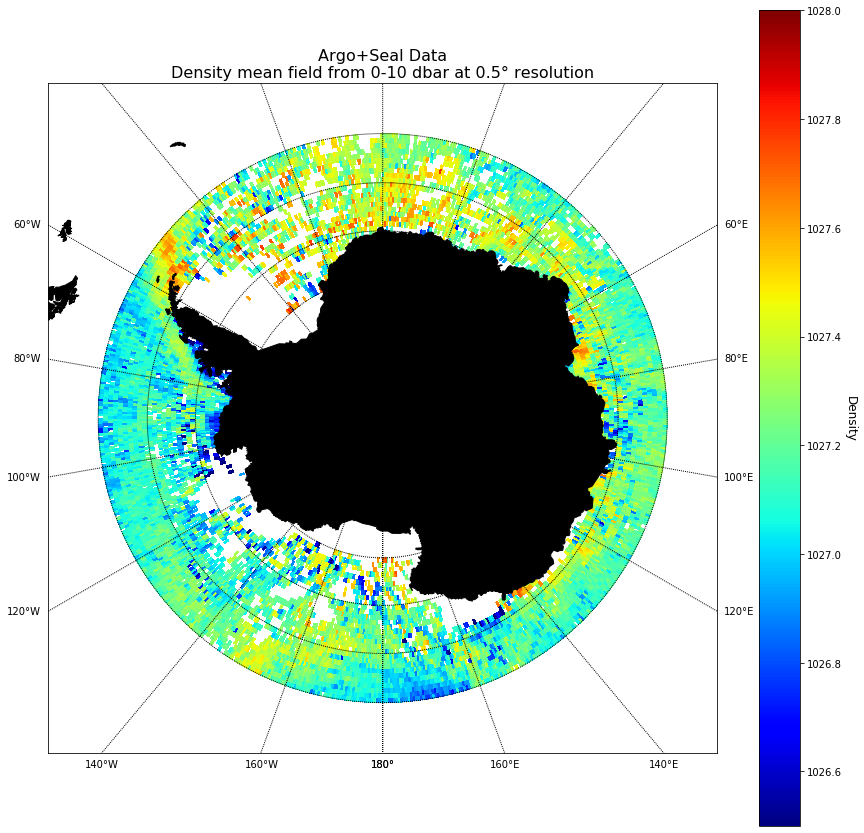

In [26]:
dens = dens0(combined_sal_grid_withdepth, combined_temp_grid_withdepth)
for db in dbars:
    dbs = "from {}-{} dbar".format(db*10, (db+1)*10)
    plot_grid(dens[:,:,db], title=comb_title + "\n" + msd + dbs, cbtitle="Density", resolution=resolution, vmin=rhomin, vmax=rhomax)
    #interp = interp_nans(dens[:,:,db])
    #print(np.nanmin(interp), np.nanmax(interp))
    #plot_grid(interp, title="Interpolated gridded seal+argo density data " + dbs, cbtitle="Density", resolution=resolution, vmin=rhomin, vmax=rhomax)

In [ ]:
plot_cross_slope(dens[:,2,:], title="Density at 179° W", cbtitle="Density", resolution=resolution)
#plot_cross_slope(interp_nans(dens[:,2,:]), title="Interpolated density at 179° W", cbtitle="Density", resolution=resolution)

In [ ]:
resolution = 2
years = [2007, 2011, 2015]
try:
    grids_per_year = np.load("grids_per_year.npy", allow_pickle=True).item()
except:
    grids_per_year = {}
    for y in years:
        for s in ["Summer", "Winter"]:
            start = datetime(y,1,1)
            end = datetime(y + 4,1,1)
            argo_temp_grid_withdepth_yearfiltered = load_netcdf_grid(with_depth=True, resolution = resolution, filter_start = start, filter_end = end, filter_season = s)
            seal_temp_grid_withdepth_yearfiltered = load_netcdf_grid("seal", with_depth=True, resolution = resolution, filter_start = start, filter_end = end, filter_season = s)
            combined_temp_grid_withdepth_yearfiltered = np.nanmean((argo_temp_grid_withdepth_yearfiltered, seal_temp_grid_withdepth_yearfiltered), axis=0)
            if y not in grids_per_year:
                grids_per_year[y] = {
                    "Winter": {},
                    "Summer": {}
                }
            grids_per_year[y][s] = {
                "argo": argo_temp_grid_withdepth_yearfiltered,
                "seal": seal_temp_grid_withdepth_yearfiltered,
                "combined": combined_temp_grid_withdepth_yearfiltered
            }
    np.save("grids_per_year", grids_per_year)

In [ ]:
plt.rcParams['figure.facecolor']='white'
db = 50
for i, y in enumerate(years):
    for s in ["Summer", "Winter"]:
        argo_temp_grid_withdepth_yearfiltered = grids_per_year[y][s]["argo"]
        seal_temp_grid_withdepth_yearfiltered = grids_per_year[y][s]["seal"]
        combined_temp_grid_withdepth_yearfiltered = grids_per_year[y][s]["combined"]
        title = f"at {db * 10}dbar from the year {y}-{y + 4} in {s}"
        plot_grid(argo_temp_grid_withdepth_yearfiltered[:,:,db], title=a_title + "\n" + title, resolution=resolution, vmin=tmin, vmax=tmax)
        plot_grid(seal_temp_grid_withdepth_yearfiltered[:,:,db], title=s_title + "\n" + title, resolution=resolution, vmin=tmin, vmax=tmax)
        plot_grid(combined_temp_grid_withdepth_yearfiltered[:,:,db], title=comb_title + "\n" + title, resolution=resolution, vmin=tmin, vmax=tmax)
        interp = interp_nans(combined_temp_grid_withdepth_yearfiltered[:,:,db])
        plot_grid(interp, title=interp_title + "\n" + title, resolution=resolution, vmin=tmin, vmax=tmax)
    
        if i > 0:
            delta = argo_temp_grid_withdepth_yearfiltered[:,:,db] - grids_per_year[years[i - 1]][s]["argo"][:,:,db]
            print(np.nanmin(delta), np.nanmean(delta), np.nanmax(delta))
            plot_grid(delta, title=comb_title + "\n" + f"Delta from {years[i - 1]} - {y} in {s} at {db}dbar", resolution=resolution)

In [ ]:
print(grids_per_year.keys())
delta = grids_per_year[2015]["Winter"]["argo"][:,:,db] - grids_per_year[2011]["Winter"]["argo"][:,:,db]
print(np.nanmax(delta))
print(np.where(delta == np.nanmax(delta)))
delta[10,636]
print(grids_per_year[2015]["Winter"]["argo"][10,636,db])
print(grids_per_year[2011]["Winter"]["argo"][10,636,db])
print(10/2, 636 /2 - 180)

In [ ]:
mask = ((argo["lat"] < -64.75) & (argo["lat"] > -65.25) & (argo["lon"] > 137.25) & (argo["lon"] < 138.75))
for i in np.flatnonzero(mask):
    pres = argo["pressure"][i] / 10
    pres = np.floor(argo["pressure"][i] / 10).astype(int)
    depthmask = pres == 50
    temps = np.copy(argo["temperature"][i][depthmask])
    print(f'i={i},lat={argo["lat"][i]},lon={argo["lon"][i]},dt={argo["datetime"][i]},temps={np.around(temps,2)},mean={np.around(np.nanmean(temps), 2)}')

In [ ]:
mask = ((argo["lat"] < -64.75) & (argo["lat"] > -65.25) & (argo["lon"] > 137.25) & (argo["lon"] < 138.75))    
fig, ax = plt.subplots(1, 1, figsize=(10,20))
ax.set_xlabel("Salinity")
ax.set_ylabel("Depth (dbar)")
ax.set_ylim(2000, 0)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

for i in np.flatnonzero(mask):
    sal = argo["salinity"][i]
    pressure = argo["pressure"][i]
    #sal = savgol_filter(sal, 69, 1)
    ax.plot(sal, pressure)